In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import keras

import sys
# sys.path.append("/Users/Work/Developer/interpretDL/interprettensor")
root_logdir = "./tf_logs"

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

    
def get1hot(y_train,y_test):
    from sklearn.preprocessing import OneHotEncoder

    enc = OneHotEncoder(categories="auto", sparse=False)
    y_train_1hot = enc.fit_transform([[label] for label in y_train]) # Since the function expects an array of "features" per sample
    y_test_1hot = enc.fit_transform([[label] for label in y_test])

    return y_train_1hot, y_test_1hot
    
tf.__version__

Using TensorFlow backend.


'1.13.1'

### Getting data from csv

In [3]:
filename = "cleaned_ADNI.csv"
raw_data = pd.read_csv(filename)
print(raw_data.info())
raw_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Columns: 299 entries, PTID to DX_bl
dtypes: float64(148), int64(148), object(3)
memory usage: 334.1+ KB
None


,PTID,scandate,G_and_S_frontomargin_SA_lh,G_and_S_frontomargin_TH_lh,G_and_S_occipital_inf_SA_lh,G_and_S_occipital_inf_TH_lh,G_and_S_paracentral_SA_lh,G_and_S_paracentral_TH_lh,G_and_S_subcentral_SA_lh,G_and_S_subcentral_TH_lh,...,S_suborbital_TH_rh,S_subparietal_SA_rh,S_subparietal_TH_rh,S_temporal_inf_SA_rh,S_temporal_inf_TH_rh,S_temporal_sup_SA_rh,S_temporal_sup_TH_rh,S_temporal_transverse_SA_rh,S_temporal_transverse_TH_rh,DX_bl
0,094_S_2216,2011-05-04 08:35:04.461,936,1.984,1158,2.107,993,2.306,1226,2.359,...,1.421,1007,1.937,763,1.759,4349,2.025,249,1.579,EMCI
1,029_S_2376,2011-07-05 18:17:58.518,855,2.160,1291,2.287,1137,1.961,1451,2.059,...,2.457,1195,1.804,635,1.970,4895,2.071,344,1.642,EMCI
2,098_S_4003,2016-05-04 15:44:47.525,849,2.122,909,2.272,788,2.430,717,2.606,...,2.222,626,1.870,784,1.826,3182,2.056,195,2.179,CN
3,021_S_2077,2014-10-21 15:26:50.834,762,2.237,969,2.141,1153,2.130,1156,2.135,...,2.880,1127,2.245,789,1.924,4399,2.014,243,1.826,EMCI
4,021_S_5099,2013-06-11 14:47:47.885,752,2.073,960,2.521,873,2.374,810,2.481,...,3.412,790,2.276,665,2.535,2914,2.168,183,2.166,EMCI


#### Add hippocampus volumes L and R
> from aseg.stat
> Also add up all volumes in aseg.stat and add up to get ICV intra cranial volume

### ANOTHER approach is to ** pretrain ** if nothing else works
- Pretrain on all 600 samples
- Freeze all but the last two layers and retrain on 143 dataset
- Make sure that test set is never seen, eevn in pretraining

In [115]:
label_col = "DX_bl"
features = raw_data.drop(columns=["PTID", "scandate",label_col])
labels = raw_data[label_col].copy()
features.head()

,G_and_S_frontomargin_SA_lh,G_and_S_frontomargin_TH_lh,G_and_S_occipital_inf_SA_lh,G_and_S_occipital_inf_TH_lh,G_and_S_paracentral_SA_lh,G_and_S_paracentral_TH_lh,G_and_S_subcentral_SA_lh,G_and_S_subcentral_TH_lh,G_and_S_transv_frontopol_SA_lh,G_and_S_transv_frontopol_TH_lh,...,S_suborbital_SA_rh,S_suborbital_TH_rh,S_subparietal_SA_rh,S_subparietal_TH_rh,S_temporal_inf_SA_rh,S_temporal_inf_TH_rh,S_temporal_sup_SA_rh,S_temporal_sup_TH_rh,S_temporal_transverse_SA_rh,S_temporal_transverse_TH_rh
0,936,1.984,1158,2.107,993,2.306,1226,2.359,443,2.338,...,254,1.421,1007,1.937,763,1.759,4349,2.025,249,1.579
1,855,2.160,1291,2.287,1137,1.961,1451,2.059,685,2.207,...,309,2.457,1195,1.804,635,1.970,4895,2.071,344,1.642
2,849,2.122,909,2.272,788,2.430,717,2.606,474,2.456,...,250,2.222,626,1.870,784,1.826,3182,2.056,195,2.179
3,762,2.237,969,2.141,1153,2.130,1156,2.135,421,2.282,...,180,2.880,1127,2.245,789,1.924,4399,2.014,243,1.826
4,752,2.073,960,2.521,873,2.374,810,2.481,460,2.331,...,197,3.412,790,2.276,665,2.535,2914,2.168,183,2.166


In [131]:
labels.value_counts()/len(labels)

EMCI    0.321678
CN      0.209790
AD      0.181818
LMCI    0.146853
SMC     0.139860
Name: DX_bl, dtype: float64

### Get 1 Hot Vector representation of the categorical labels

In [117]:
# Converting labels to 1-Hot Vectors
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(categories="auto", sparse=False)
labels_1hot = enc.fit_transform([[label] for label in labels]) # Since the function expects an array of "features" per sample

print(enc.categories_)
print(labels[:5])
labels_1hot[:5]
# X_train.shape[1]

[array(['AD', 'CN', 'EMCI', 'LMCI', 'SMC'], dtype=object)]
0    EMCI
1    EMCI
2      CN
3    EMCI
4    EMCI
Name: DX_bl, dtype: object


array([[0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

# Normalizing training inputs

Does not work at all without normalization. The ranges for surface area and thickness are vastly different.

In [118]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() #x-u/sd
features = scaler.fit_transform(features) # Note that features is no longer a dataframe

/Users/Work/anaconda3/envs/condaflow/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/Work/anaconda3/envs/condaflow/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [119]:
from sklearn.model_selection import StratifiedShuffleSplit

# The train set will have equal amounts of each target class
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(features, labels):
    X_train = features[train_index]
    y_train_1hot = labels_1hot[train_index]
    X_test = features[test_index]
    y_test_1hot = labels_1hot[test_index]

In [120]:
X_train.shape

(114, 296)

### Building the network

We will build a fully connected (slightly) deep network with no drop outs or batch normalization for now

In [126]:
from keras import optimizers
from keras import regularizers

def build_dnn(num_features):
    keras.backend.clear_session()
    reset_graph()
    
    reg_scale = 0.0001 # For L1 Reg
    my_reg = regularizers.l1(reg_scale) # Can change this if needed
    
    dnn = keras.models.Sequential()

    Dense = keras.layers.Dense

    # Using He initialization
    he_init = tf.contrib.layers.variance_scaling_initializer()
    # he_init =keras.initializers.VarianceScaling()

    dnn.add(Dense(units = 300, activation="elu", input_dim=num_features,
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.5))
    dnn.add(Dense(units = 150, activation="elu",
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.2))
    dnn.add(Dense(units=50, activation='elu',
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.5))
    
    dnn.add(Dense(units=5, activation="softmax", kernel_initializer=he_init)) # 5 labels -> logits for now

    dnn.compile(loss='categorical_crossentropy',
                  optimizer="adam",
                  metrics=['accuracy'])
    
    return dnn

def build_test_dnn(num_features):
    keras.backend.clear_session()
    reset_graph()
    
    reg_scale = 0.001 # For L1 Reg
    my_reg = regularizers.l1(reg_scale) # Can change this if needed
    
    dnn = keras.models.Sequential()

    Dense = keras.layers.Dense

    # Using He initialization
    he_init = tf.contrib.layers.variance_scaling_initializer()

    dnn.add(Dense(units = 300, input_dim=num_features,
                  kernel_initializer=he_init,
                  kernel_regularizer = my_reg,
                  activity_regularizer = my_reg
                 ))
    dnn.add(keras.layers.Activation("elu"))
    dnn.add(keras.layers.Dropout(0.5))
    
    dnn.add(Dense(units = 150, activation="elu",
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.5))
    
    dnn.add(Dense(units=50, activation='elu',
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
#     dnn.add(keras.layers.Dropout(0.1))
    
    dnn.add(Dense(units=5, activation="softmax", kernel_initializer=he_init)) # 5 labels -> logits for now

    dnn.compile(loss='categorical_crossentropy',
                  optimizer="adam",
                  metrics=['accuracy'])
    
    return dnn

dnn = build_test_dnn(X_train.shape[1])
dnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 300)               89100     
_________________________________________________________________
activation_1 (Activation)    (None, 300)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 150)               45150     
_________________________________________________________________
dropout_2 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                7550      
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 255       
Total para

In [128]:
dnn = build_dnn(X_train.shape[1])
history = dnn.fit(X_train, y_train_1hot, epochs=40, batch_size = 20, validation_data=(X_test, y_test_1hot))

Train on 114 samples, validate on 29 samples
Epoch 1/40
114/114 [==============================] - 0s 3ms/step - loss: 4.8256 - acc: 0.2018 - val_loss: 2.8194 - val_acc: 0.3793
Epoch 2/40
114/114 [==============================] - 0s 131us/step - loss: 4.1358 - acc: 0.2895 - val_loss: 2.8804 - val_acc: 0.4483
Epoch 3/40
114/114 [==============================] - 0s 137us/step - loss: 3.3399 - acc: 0.4474 - val_loss: 2.8257 - val_acc: 0.4483
Epoch 4/40
114/114 [==============================] - 0s 145us/step - loss: 3.2726 - acc: 0.4211 - val_loss: 2.7917 - val_acc: 0.4483
Epoch 5/40
114/114 [==============================] - 0s 156us/step - loss: 3.2807 - acc: 0.4561 - val_loss: 2.7205 - val_acc: 0.4483
Epoch 6/40
114/114 [==============================] - 0s 150us/step - loss: 2.7406 - acc: 0.4211 - val_loss: 2.7881 - val_acc: 0.4138
Epoch 7/40
114/114 [==============================] - 0s 157us/step - loss: 2.4937 - acc: 0.5526 - val_loss: 2.8642 - val_acc: 0.3793
Epoch 8/40
114/114 

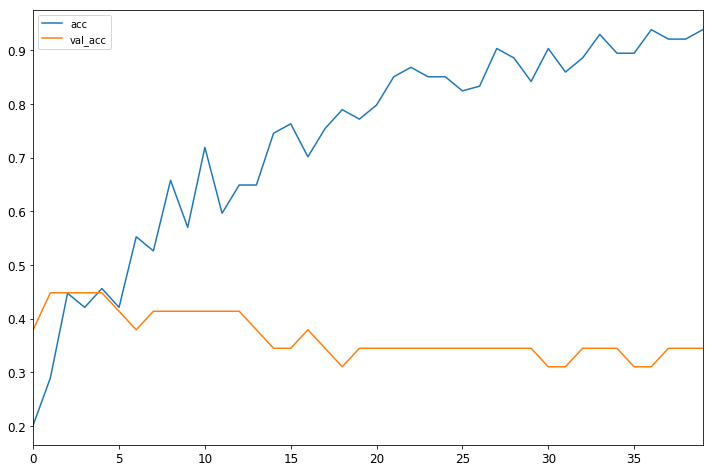

In [129]:
df = pd.DataFrame(history.history)

df[["acc","val_acc"]].plot(figsize=(12,8))

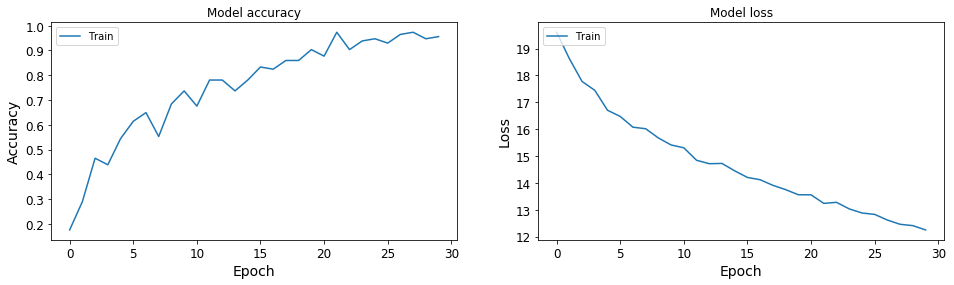

In [109]:
def plot_history(history):
    fig, axs = plt.subplots(1, 2, figsize=(16,4))

    # Plot training & validation accuracy values
    axs[0].plot(history.history['acc'])
    # plt.plot(history.history['val_acc'])
    axs[0].set(title='Model accuracy', ylabel='Accuracy', xlabel='Epoch')
    axs[0].legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    axs[1].plot(history.history['loss'])
    # plt.plot(history.history['val_loss'])
    axs[1].set(title='Model loss',ylabel='Loss', xlabel='Epoch')
    axs[1].legend(['Train', 'Test'], loc='upper left')
    plt.show()

plot_history(history)

In [111]:
loss_and_metrics = dnn.evaluate(X_test, y_test_1hot)
print("Scores on test set: loss={:0.3f} accuracy={:.4f}".format(*loss_and_metrics))

29/29 [==============================] - 0s 49us/step
Scores on test set: loss=18.694 accuracy=0.2414


In [110]:
loss_and_metrics = dnn.evaluate(features, labels_1hot)
print("Scores on test set: loss={:0.3f} accuracy={:.4f}".format(*loss_and_metrics))

143/143 [==============================] - 0s 47us/step
Scores on test set: loss=15.086 accuracy=0.8462


In [112]:
features.shape

(143, 296)

In [108]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10)
num_features = features.shape[1]

for train_index, test_index in kf.split(features):
    X_train = features[train_index]
    y_train_1hot = labels_1hot[train_index]
    X_test = features[test_index]
    y_test_1hot = labels_1hot[test_index]
    
    dnn = build_dnn(num_features)
    history = dnn.fit(X_train, y_train_1hot, epochs=30, batch_size = 20, validation_data=(X_test, y_test_1hot))
    print("-----"*10)

Train on 128 samples, validate on 15 samples
Epoch 1/30
128/128 [==============================] - 0s 3ms/step - loss: 3.0956 - acc: 0.2266 - val_loss: 1.6730 - val_acc: 0.2667
Epoch 2/30
128/128 [==============================] - 0s 133us/step - loss: 1.9500 - acc: 0.4297 - val_loss: 1.5568 - val_acc: 0.3333
Epoch 3/30
128/128 [==============================] - 0s 160us/step - loss: 1.3267 - acc: 0.5547 - val_loss: 1.6679 - val_acc: 0.2667
Epoch 4/30
128/128 [==============================] - 0s 148us/step - loss: 1.0680 - acc: 0.6172 - val_loss: 1.5336 - val_acc: 0.3333
Epoch 5/30
128/128 [==============================] - 0s 149us/step - loss: 0.9756 - acc: 0.6562 - val_loss: 1.6343 - val_acc: 0.2000
Epoch 6/30
128/128 [==============================] - 0s 159us/step - loss: 0.7541 - acc: 0.6797 - val_loss: 1.7983 - val_acc: 0.2000
Epoch 7/30
128/128 [==============================] - 0s 156us/step - loss: 0.7241 - acc: 0.7344 - val_loss: 1.8254 - val_acc: 0.3333
Epoch 8/30
128/128 